In [1]:
import proplot as pplt

from skimage.data import immunohistochemistry
import matplotlib.pyplot as plt

# Input Information

## General Parameters

In [2]:
import numpy as np
# general
voltage = 80 # kV
semiconv = 20 # mrad
npixels = 128 # pixels

# sampling
sampling = 0.2 # Angstrom

X: list # Angstrom
Y: list # Angstrom
xx, yy = np.meshgrid(np.arange(14, 85, 1), np.arange(14, 85, 1))
X = xx.ravel()
Y = yy.ravel()

In [3]:
input_mag = np.loadtxt("12051309_freq_corr.txt")
input_mag -= input_mag.min()
input_mag = input_mag/input_mag.max() * np.pi - np.pi/2

In [4]:
# images
object_wf : np.ndarray

from matplotlib import pyplot as plt
from skimage import color
#image = immunohistochemistry() #plt.imread("FluorescentCells.jpg")
# image_hsv = color.rgb2hsv(image)

def sigma_e(accl):
    '''accl in kV'''
    from ptychography40.reconstruction.common import wavelength
    wl = wavelength(accl)
    accl *= 1e3

    import scipy.constants as sc
    #h  = sc.physical_constants["Planck constant"][0]
    c  = sc.physical_constants["speed of light in vacuum"][0]
    m0 = sc.physical_constants["electron mass"][0]
    e  = sc.physical_constants["elementary charge"][0]

    sigma_e = 2 * np.pi / (wl * accl) * (
        (m0 * c**2 + e*accl) /
        (2*m0 * c**2 + e*accl)
    )
    return sigma_e

object_amp = np.ones(shape=input_mag.shape)
object_phase = input_mag

from skimage.filters import butterworth
object_phase = butterworth(object_phase, 0.2, high_pass=False)
#object_wf = object_amp * np.exp(1j*sigma_e(voltage)*object_phase)
object_wf = object_amp * np.exp(1j*object_phase)

In [5]:
np.save("object_phase", object_phase)

# Preprocessing

The probe generation will only consider the aperture here, not including the aberration. Three parameters above are used here: the sampling rate $\Delta x$, the number of pixels of detector $n$, and the convergence semi-angle $\alpha$.

First we need to calculate the resolution $\Delta r$ (unit $\mathrm{rad/pixel}$) in the reciprocal. This is done by the following equation:
$$\Delta r = \frac{\lambda}{n\Delta x}$$

According to the parameters provide above this resolution is

In [6]:
detector_psize = 5.5e-5 # m

from ptychography40.reconstruction.common import wavelength
from IPython.display import display, Math
rsampling = wavelength(voltage) * 1e10 / (npixels * sampling) * 1e3 # mrad
display(Math(r"\Delta r = {}\quad\mathrm{{mrad/pixel}}".format(rsampling)))

distance = 1 / (rsampling * 1e-3) * detector_psize
display(f"camera distance = {distance} m")
rr = wavelength(voltage) / rsampling * npixels
semiconv / rsampling

<IPython.core.display.Math object>

'camera distance = 0.03371876760634542 m'

12.261370038671064

In [7]:
# Generate boundary for each coordinates
Xc = X/sampling
Yc = Y/sampling
Xb: list = [slice(int(np.floor(x - npixels/2)), int(np.floor(x - npixels/2) + npixels)) for x in Xc]
Yb: list = [slice(int(np.floor(y - npixels/2)), int(np.floor(y - npixels/2) + npixels)) for y in Yc]

from fitaber import *

probe_wf: np.ndarray

aberration_list = CoefficientList([
        *from_uhlemann("C1", Polar(-200e-10, 0))
    ])
print(aberration_list.format())

aberrations = aber(aberration_list, scale=rsampling * 1e-3, size=npixels, kV=80)
xcoords = np.arange(-rsampling * (npixels/2), rsampling * (npixels/2), rsampling)
ycoords = np.arange(-rsampling * (npixels/2), rsampling * (npixels/2), rsampling)
xx, yy = np.meshgrid(xcoords, ycoords)
rprobe = np.where(xx ** 2 + yy ** 2 <= semiconv ** 2, np.exp(-1j*aberrations), 0)
probe_wf = np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(rprobe)))
probe_wf /= np.sum(np.abs(probe_wf)) * sampling**2

[
[ 0]:     C1: c(2,0) = C(1,0) = Polar(        20 nm,        180 °)
]



In [8]:
np.save("probe_wf", probe_wf)

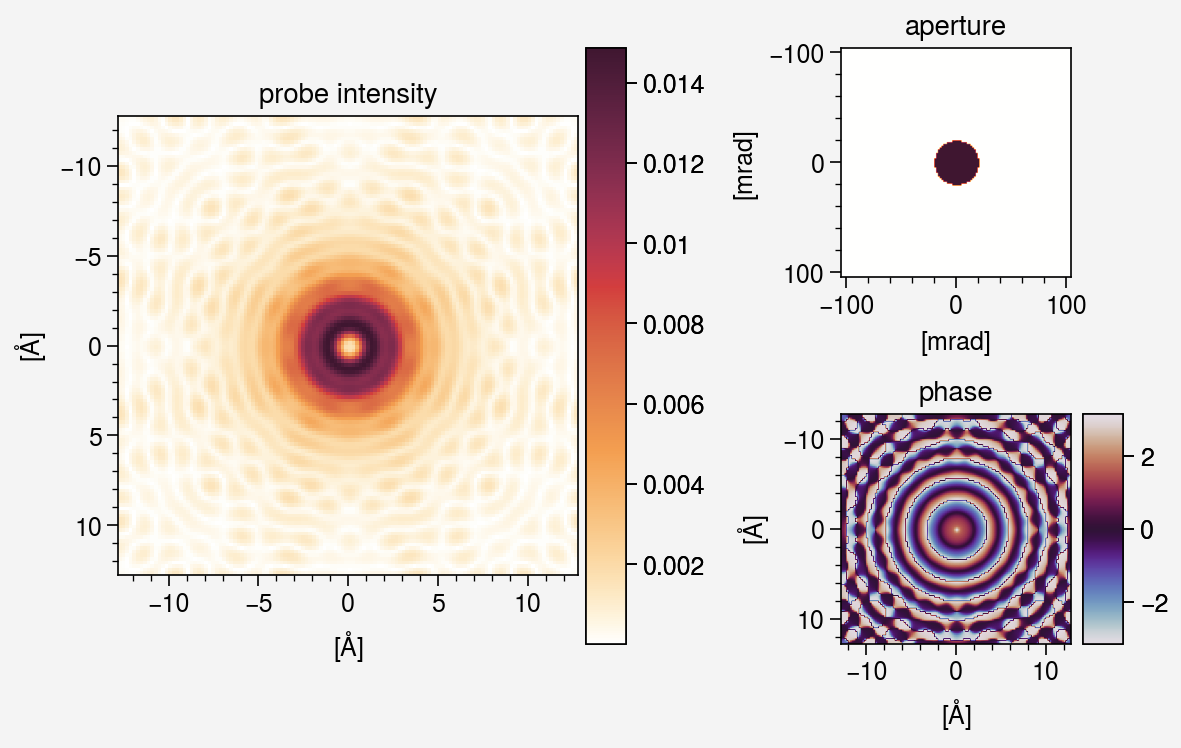

In [9]:
%matplotlib inline
import proplot as pplt
fig, axs = pplt.subplots(share=False, figwidth="15cm",
    array = [
    [2, 2, 1],
    [2, 2, 3]
    ]
)
axs[0].imshow(np.where(abs(rprobe), 1, 0), extent=[
    -rsampling * (npixels/2), rsampling * (npixels/2),
    rsampling * (npixels/2), -rsampling * (npixels/2)
    ])
axs[0].format(title="aperture", xlabel="[mrad]", ylabel="[mrad]")

m = axs[1].imshow(np.abs(probe_wf), extent=[
    -sampling * (npixels/2), sampling * (npixels/2),
    sampling * (npixels/2), -sampling * (npixels/2)
    ])
axs[1].colorbar(m, loc="r")
axs[1].format(title="probe intensity", xlabel="[$\AA$]", ylabel="[$\AA$]")

m = axs[2].imshow(np.angle(probe_wf), cyclic=True,
                  vmin=-np.pi, vmax=np.pi,
                  extent=[
    -sampling * (npixels/2), sampling * (npixels/2),
    sampling * (npixels/2), -sampling * (npixels/2)
    ])
axs[2].colorbar(m, loc="r")
axs[2].format(title="phase", xlabel="[$\AA$]", ylabel="[$\AA$]")
pplt.show()

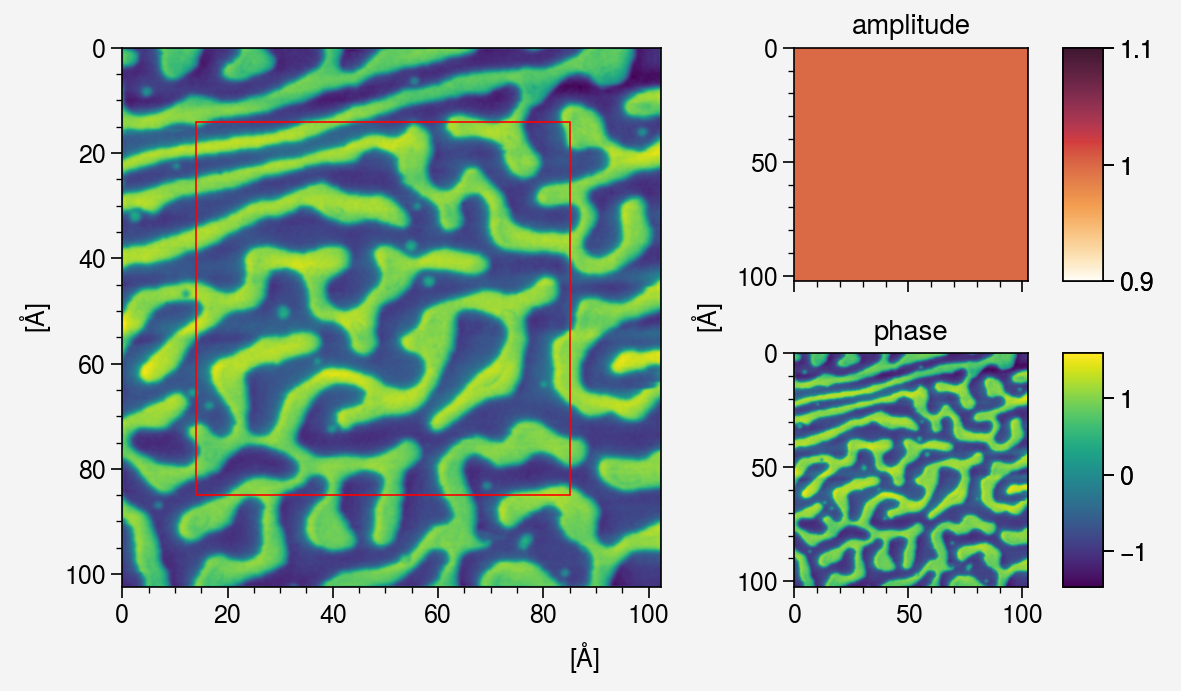

In [10]:
%matplotlib inline
import proplot as pplt
fig, axs = pplt.subplots(figwidth="15cm",
    array=[
    [1,1,2],
    [1,1,3]
    ]
)
axs[0].imshow(object_phase, extent=[0, sampling*object_wf.shape[1], sampling*object_wf.shape[0], 0], cmap="viridis")
axs[0].format(xlabel="[$\AA$]", ylabel="[$\AA$]")

from matplotlib import pyplot as plt
#for i, (xi, yi) in enumerate(zip(X, Y)):
    #axs[0].add_artist(plt.Circle((xi,yi), sampling*npixels/2, fill=False, color="red"))
    #axs[0].plot(xi, yi, ".", color="red", alpha=0.5)
    #axs[0].text(xi, yi, f"{i}", color="red")
axs[0].add_artist(plt.Rectangle((14,14), 71, 71, fill=False, color="red"))

m = axs[1].imshow(object_amp, extent=[0, sampling*object_wf.shape[1], sampling*object_wf.shape[0], 0])
axs[1].colorbar(m, loc="r")
axs[1].format(title="amplitude", xlabel="[$\AA$]", ylabel="[$\AA$]")

m = axs[2].imshow(object_phase, extent=[0, sampling*object_wf.shape[1], sampling*object_wf.shape[0], 0], cmap="viridis")
axs[2].colorbar(m, loc="r")
axs[2].format(title="phase", xlabel="[$\AA$]", ylabel="[$\AA$]")

pplt.show()

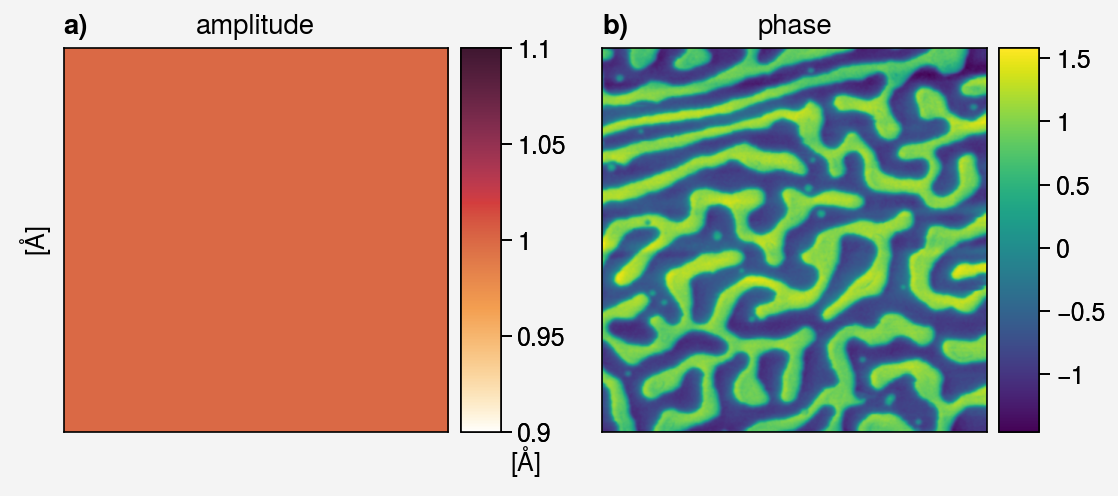

In [15]:
%matplotlib inline
import proplot as pplt
fig, axs = pplt.subplots(figwidth="14.2cm",
    array=[
    [1,2]
    ],
    xticks=[], yticks=[],
    abc='a)'
)
# axs[0].imshow(object_phase, extent=[0, sampling*object_wf.shape[1], sampling*object_wf.shape[0], 0], cmap="viridis")
# axs[0].format(xlabel="[$\AA$]", ylabel="[$\AA$]")

# from matplotlib import pyplot as plt
# #for i, (xi, yi) in enumerate(zip(X, Y)):
#     #axs[0].add_artist(plt.Circle((xi,yi), sampling*npixels/2, fill=False, color="red"))
#     #axs[0].plot(xi, yi, ".", color="red", alpha=0.5)
#     #axs[0].text(xi, yi, f"{i}", color="red")
# axs[0].add_artist(plt.Rectangle((14,14), 71, 71, fill=False, color="red"))

m = axs[0].imshow(object_amp, extent=[0, sampling*object_wf.shape[1], sampling*object_wf.shape[0], 0])
axs[0].colorbar(m, loc="r")
axs[0].format(title="amplitude", xlabel="[$\AA$]", ylabel="[$\AA$]")

m = axs[1].imshow(object_phase, extent=[0, sampling*object_wf.shape[1], sampling*object_wf.shape[0], 0], cmap="viridis")
axs[1].colorbar(m, loc="r")
axs[1].format(title="phase", xlabel="[$\AA$]", ylabel="[$\AA$]")

pplt.show()

fig.savefig("mfm-original-amp-phase")

# Simulation

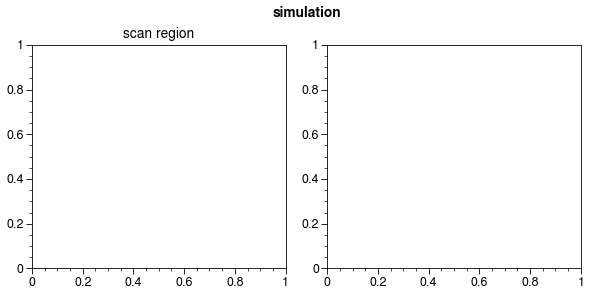

In [11]:
%matplotlib widget
fig, (ax1, ax2) = pplt.subplots(nrows=1, ncols=2, share=False,
                                figwidth="15cm", figheight="7.5cm",
                                suptitle="simulation")
ax1.format(title="scan region")

DPs = []
for i, (xs, ys) in enumerate(zip(Xb, Yb)):
    DP = np.abs(np.fft.ifftshift(np.fft.fft2(np.fft.fftshift(probe_wf * object_wf[ys, xs])))) ** 2
    DPs.append(DP)

def animate(i):
    xi, yi = X[i], Y[i]
    ax1.clear()
    ax1.imshow(object_phase, extent=[0, sampling*object_wf.shape[1], sampling*object_wf.shape[0], 0])
    ax1.add_artist(plt.Circle((xi,yi), sampling*npixels/2, fill=True, color="red", alpha=0.2))
    ax1.plot(xi, yi, ".", color="red")
    ax1.text(xi, yi, f"{i}", color="red")
    ax1.format(xlabel="[$\AA$]", ylabel="[$\AA$]")

    DP = DPs[i]
    ax2.clear()
    ax2.imshow(DP, extent=[
        -rsampling * (npixels/2), rsampling * (npixels/2),
        rsampling * (npixels/2), -rsampling * (npixels/2)
        ])
    ax2.format(title=f"DP intensity (i = {i})", xlabel="[rad]", ylabel="[rad]")

from matplotlib.animation import FuncAnimation
anim = FuncAnimation(fig, animate, frames=len(Xb), interval=1, blit=True)

In [12]:
#from matplotlib.animation import FFMpegWriter
#writervideo = FFMpegWriter(fps=4)
#anim.save('simulation.mp4', writer=writervideo)

In [13]:
np.array(DPs).astype(np.float32).tofile("SimpleSim.bin")

In [14]:
len(DPs)

5041